<a href="https://colab.research.google.com/github/aditya-saurabh/generative-adversial-network/blob/master/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# downloading the maps dataset

!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz 

--2020-06-18 14:33:44--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  2.92MB/s    in 1m 47s  

2020-06-18 14:35:31 (2.23 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
#unzipping the file

!gzip -d '/content/maps.tar' 
!tar xvf '/content/maps.tar'

In [3]:
# function to load images

import tensorflow as tf
import os
import numpy as np

def load_images(path, size=(256,512)):
  files = os.listdir(path)
  X = []
  y = []

  for fn in files:
    destination = os.path.join(path, fn)
    image = tf.keras.preprocessing.image.load_img(destination, target_size = size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    source, target = image[:, :256], image[:, 256:]

    X.append(source)
    y.append(target)
  
  X = np.array(X)
  y = np.array(y)

  #normalizing
  X = (X-127.5)/127.5
  y = (y-127.5)/127.5
  print(f'Shape of the source images {X.shape}\nShape of the target images {y.shape}')
  return X, y

In [4]:
# separating the source and target image for training data

path_train = '/content/maps/train'
X_train, y_train = load_images(path_train)



Shape of the source images (1096, 256, 256, 3)
Shape of the target images (1096, 256, 256, 3)


In [5]:
# separating the source and target image for validation data

path_val = '/content/maps/val'
X_test, y_test = load_images(path_val)

Shape of the source images (1098, 256, 256, 3)
Shape of the target images (1098, 256, 256, 3)


In [6]:
# plotting images

from matplotlib import pyplot as plt
def plot(src, target, n = 5):
  src = (src+1)/2
  target = (target+1)/2
  indices = np.random.choice(range(src.shape[0]), n)

  n_rows = n
  n_cols = 2

  plt.figure(figsize = (20,12))
  for i in range(n):
    plt.subplot(n_rows, n_cols, 2*(i+1)-1)
    plt.imshow(src[indices[i]])
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2*(i+1))
    plt.imshow(target[indices[i]])
    plt.axis('off')
  
  plt.show()


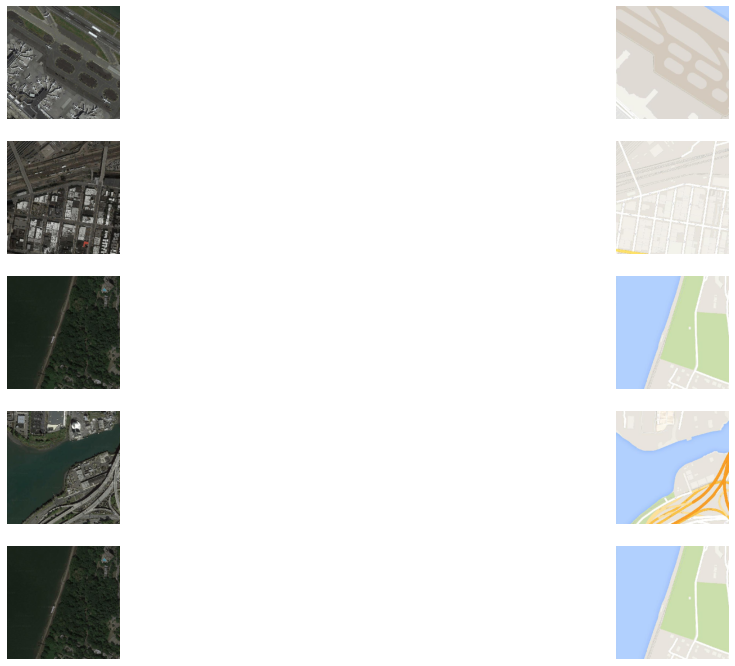

In [7]:
plot(X_train, y_train)

In [8]:
# discriminator

def discriminator(shape=(256,256,3)):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)

  src_image = tf.keras.layers.Input(shape=shape)
  tar_image = tf.keras.layers.Input(shape=shape)

  merged = tf.keras.layers.Concatenate()([src_image, tar_image])

  #C64
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C128
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C256
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C512
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #second last layer
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #patch output
  d = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch = tf.keras.layers.Activation('sigmoid')(d)

  #define model
  model = tf.keras.models.Model([src_image, tar_image], patch)

  #optimiser
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

  #compiling the model
  model.compile(optimizer=opt, loss='binary_crossentropy', loss_weights=0.5)

  return model

In [9]:
# encoder-decoder blocks

def encoder_block(input, filters, batch_norm=True):
  #weights initializer
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  #Conv layer
  e = tf.keras.layers.Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input)
  #batch normalisation
  if batch_norm:
    e = tf.keras.layers.BatchNormalization()(e, training=True)
  #Leaky ReLU activation
  e = tf.keras.layers.LeakyReLU(alpha=0.2)(e)

  return e

def decoder_block(input, skip_in, filters, dropout=True):
  #weight initializer
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  #upsampling layer
  d = tf.keras.layers.Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input)
  #dropout layer
  if dropout:
    d = tf.keras.layers.Dropout(0.5)(d, training=True)
  #merge with skip connections
  d = tf.keras.layers.Concatenate()([d, skip_in])
  #relu activation
  d = tf.keras.layers.Activation('relu')(d)

  return d

In [10]:
# generator
def generator(shape=(256,256,3)):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)

  input_layer = tf.keras.layers.Input(shape=shape)
  #encoder model
  e1 = encoder_block(input_layer, 64, False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)
  #bottleneck layer
  b = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = tf.keras.layers.Activation('relu')(b)
  #decoder layer
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  #output
  output = tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = tf.keras.layers.Activation('tanh')(output)
  #define model
  model = tf.keras.models.Model(input_layer, out_image)

  return model

In [11]:
# gan
def gan(gen_model, dis_model, shape=(256,256,3)):
  dis_model.trainable = False
  src = tf.keras.layers.Input(shape=shape)
  gen_out = gen_model(src)
  dis_out = dis_model([src, gen_out])

  model = tf.keras.models.Model(src, [dis_out, gen_out])
  #compile
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(optimizer=opt, loss=['binary_crossentropy', 'mae'], loss_weights=[1,100])

  return model


In [12]:
from matplotlib import pyplot

def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+21)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [13]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [15]:
# parameters
epochs = 20
batch_size = 1
steps = int(X_train.shape[0]/batch_size)

In [16]:
#training

def train(dis_model, gen_model, gan_model, epochs=100, batch_size=1):
  n_patch = dis_model.output_shape[1]
  for i in range(epochs):
    for j in range(steps):
      X_real_src = X_train[j*(batch_size):(j+1)*batch_size]
      X_real_target = y_train[j*(batch_size):(j+1)*batch_size]
      y_real = np.ones((batch_size, n_patch, n_patch)) 

      X_fake = gen_model(X_real_src)
      y_fake = np.zeros((batch_size, n_patch, n_patch))

      d_loss1 = dis_model.train_on_batch([X_real_src, X_real_target], y_real)
      d_loss2 = dis_model.train_on_batch([X_real_src, X_fake], y_fake)

      g_loss, _, _ = gan_model.train_on_batch(X_real_src, [y_real, X_real_target])

      print('>%d, %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, j+1, d_loss1, d_loss2, g_loss))
    
    if i%5 == 0:
      summarize_performance(i, gen_model, [X_train,y_train])





In [17]:
image_shape = (256,256,3)

dis = discriminator(image_shape)
gen = generator(image_shape)

gan_model = gan(gen, dis, image_shape)

In [ ]:
train(dis, gen, gan_model, 50, batch_size)

Streaming output truncated to the last 5000 lines.
>43, 672, d1[0.000] d2[0.000] g[2.989]
>43, 673, d1[0.000] d2[0.000] g[0.804]
>43, 674, d1[0.000] d2[0.000] g[1.999]
>43, 675, d1[0.000] d2[0.000] g[3.057]
>43, 676, d1[0.000] d2[0.000] g[1.128]
>43, 677, d1[0.000] d2[0.000] g[3.141]
>43, 678, d1[0.000] d2[0.000] g[4.461]
>43, 679, d1[0.000] d2[0.000] g[3.766]
>43, 680, d1[0.000] d2[0.000] g[3.589]
>43, 681, d1[0.000] d2[0.000] g[3.136]
>43, 682, d1[0.000] d2[0.000] g[3.074]
>43, 683, d1[0.000] d2[0.000] g[3.512]
>43, 684, d1[0.000] d2[0.000] g[5.199]
>43, 685, d1[0.000] d2[0.000] g[3.261]
>43, 686, d1[0.000] d2[0.000] g[3.658]
>43, 687, d1[0.000] d2[0.000] g[1.007]
>43, 688, d1[0.000] d2[0.000] g[2.529]
>43, 689, d1[0.000] d2[0.000] g[1.510]
>43, 690, d1[0.000] d2[0.000] g[0.587]
>43, 691, d1[0.000] d2[0.000] g[1.291]
>43, 692, d1[0.000] d2[0.000] g[3.125]
>43, 693, d1[0.000] d2[0.000] g[1.307]
>43, 694, d1[0.000] d2[0.000] g[3.018]
>43, 695, d1[0.000] d2[0.000] g[5.141]
>43, 696, d1[

In [ ]:
# mounting google drive to load the weights

from google.colab import drive
drive.mount('/content/gdrive')

model_weights = '/content/gdrive/My Drive/model_000061.h5'

In [37]:
# loading weights to the generator model

gen = tf.keras.models.load_model(model_weights)

In [46]:
# making predictions on the validation data

def plot_test_data(n_images):

  indices = np.random.choice(range(X_test.shape[0]), n_images)

  test_set_src = X_test[indices]
  test_set_tar = y_test[indices]
  out = gen.predict(test_set_src)

  plt.figure(figsize=(20,12))

  for i in range(n_images):
    plt.subplot(n_images, 3, 3*i+1)
    img_src = (test_set_src[i]+1)/2
    plt.imshow(img_src)
    plt.title('source image')
    plt.axis('off')

    plt.subplot(n_images, 3, 3*i+2)
    tar_img = (test_set_tar[i]+1)/2
    plt.imshow(tar_img)
    plt.title('target image')
    plt.axis('off')

    plt.subplot(n_images, 3, 3*i+3)
    out_img = (out[i]+1)/2
    plt.imshow(out_img)
    plt.title('generated output image')
    plt.axis('off')


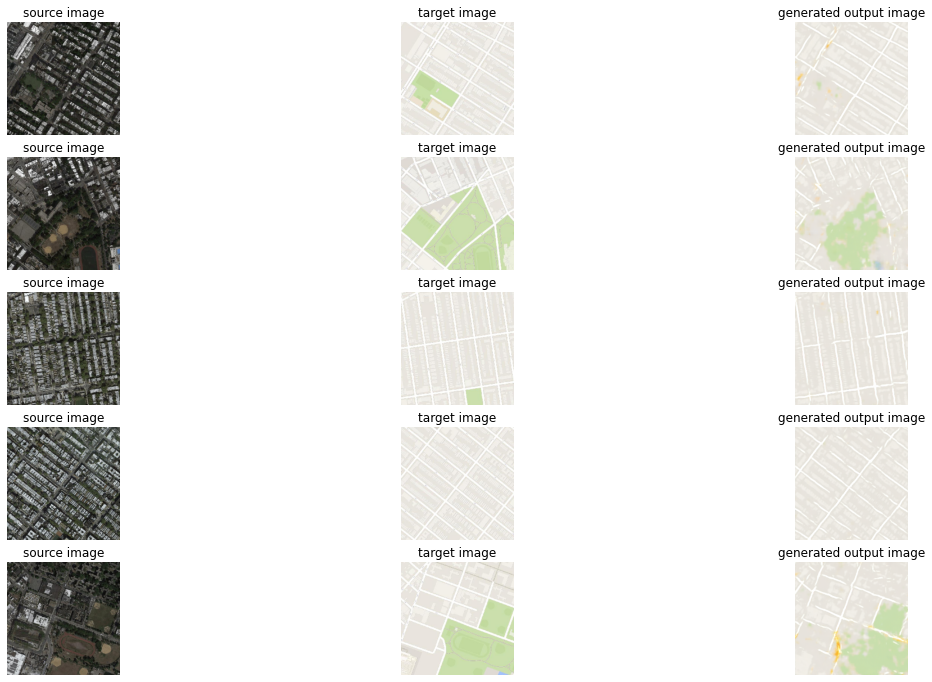

In [48]:
# plotting the generated ouput

n_images = 5
plot_test_data(n_images)

### This is the result I got after training for about 60 epochs.
### If you have any doubt or need further clarification on any part of the code, or need to download the weights, feel free to write to saurabhaaditya12@gmail.com###